<a href="https://colab.research.google.com/github/GreatGameDota/OSIC-Pulmonary-Fibrosis-Prediction/blob/master/OSIC_Quantile_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Oct  7 21:30:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Download Data

In [3]:
import json
import zipfile
import os
os.chdir('/content')

!pip install kaggle --quiet

api_token = {"username":"greatgamedota","key":"8d2d163f0f1ccfe39e9c08b3da0c40fc"} # Get the key from create new api token on https://www.kaggle.com/greatgamedota/account
!mkdir /root/.kaggle # create a dir for key
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json # make sure no one else can read the key

if not os.path.isdir('train_images/'):
  # !kaggle datasets download -d greatgamedota/osic-segmented-lungs2
  # !unzip -q osic-segmented-lungs2.zip
  # !rm osic-segmented-lungs2.zip
  
  # !kaggle datasets download -d greatgamedota/osic-segmented-lungs
  # !unzip -q osic-segmented-lungs.zip
  # !rm osic-segmented-lungs.zip

  # !kaggle datasets download -d greatgamedota/osic-lung-images
  # !unzip -q osic-lung-images.zip
  # !rm osic-lung-images.zip

  !kaggle datasets download -d greatgamedota/osic-windowed-lung-images
  !unzip -q osic-windowed-lung-images.zip
  !rm osic-windowed-lung-images.zip

  !kaggle datasets download -d greatgamedota/osic-traincsv
  !unzip -q osic-traincsv.zip
  !rm osic-traincsv.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists


#### .

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import re
import glob
import math
from tqdm import tqdm,trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp

# from apex import amp

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold, GroupKFold, GroupShuffleSplit

class config:
    epochs = 30
    batch_size = 4
    input_D = 30
    input_H = 512
    input_W = 512
    n_seg_classes = 3 # previously 1
    # meta_features = 4
    meta_features = 9 # previously 6
    IMAGE_PATH = 'train_images/'
    # IMAGE_PATH = 'train_images/'
    TEST_PATH = 'test/'
    # lr = 1e-4
    # lr = 0.1
    lr = 0.003
    # lr = 3e-4
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225],
    seed = 42
    mixup = 0
    cutmix = 0
    accumulation_steps = 1
    single_fold = 0
    folds = 5
    apex = False
    scale = False # doesnt work in kaggle kernals
#     label_smoothing = 0.03
#     pos_weight = 1
    quantiles = (0.2, 0.5, 0.8)

import random
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.seed)

In [5]:
root = r'./'

train_df = pd.read_csv('{}train.csv'.format(root))
train_df.drop_duplicates(keep=False, inplace=True, subset=['Patient', 'Weeks'])
# sample = pd.read_csv('{}/sample_submission.csv'.format(root))

bad_ids = [
    'ID00026637202179561894768', # new images fail
    'ID00027637202179689871102', # works
    'ID00078637202199415319443', # works
    'ID00128637202219474716089', # fails
    
    'ID00132637202222178761324', # fails

    'ID00283637202278714365037'  # works
]

for id in bad_ids:
  train_df = train_df.drop(pd.Index(np.where(train_df['Patient']==id)[0]), inplace=False).reset_index(drop=True)

In [6]:
# indices = np.arange(len(train_df))
patients = train_df['Patient'].unique()
indices = np.arange(len(patients))
# train_indices, my_test_indices = next(GroupShuffleSplit(test_size=0.01, random_state=config.seed).split(indices, groups=patients))
# random.shuffle(train_indices)
random.shuffle(indices)

splits = list(GroupKFold(n_splits=config.folds).split(indices, groups=patients[indices]))

folds = np.zeros(len(patients))
train_df['fold'] = -1
for fld, (_, test_idx) in enumerate(splits):
    # train_df.iloc[test_idx, -1] = fld
    folds[test_idx] = fld

In [7]:
def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30] 
    
    if df.Sex.values[0] == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 

targets = []
tab = []
P = []
for i, p in enumerate(train_df.Patient.unique()):
    sub = train_df.loc[train_df.Patient == p, :] 
    
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]

    targets.append(a)
    P.append(p)
    tab.append(get_tab(sub))

patients = pd.DataFrame({'Patient': patients, 'target': targets, 'meta': tab, 'fold': folds})
patients.head()

,Patient,target,meta,fold
0,ID00007637202177411956430,-3.167126,"[1.6333333333333333, 1.0, 1.0, 1.0]",0.0
1,ID00009637202177434476278,-9.379955,"[1.3, 1.0, 1.0, 1.0]",3.0
2,ID00010637202177584971671,-17.042803,"[1.0, 1.0, 1.0, 1.0]",3.0
3,ID00011637202177653955184,-4.548925,"[1.4, 1.0, 1.0, 1.0]",4.0
4,ID00012637202177665765362,-8.543079,"[1.1666666666666667, 1.0, 0.0, 0.0]",1.0


In [8]:
for i,p in enumerate(patients['Patient'].values):
  idxs = train_df[train_df.Patient==p]['fold'].index
  for idx in idxs:
    train_df.iloc[idx,-1] = patients.fold.values[i]

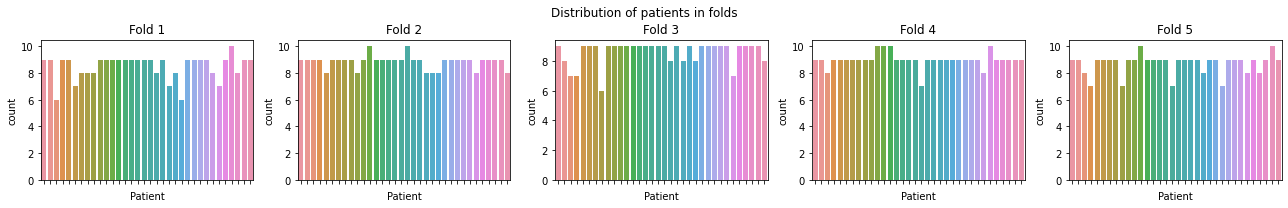

In [9]:
import seaborn as sns

fig, ax = plt.subplots(1, 5, figsize=(18, 3))

for i in range(5):
    sns.countplot(train_df[train_df['fold'] == i]['Patient'], ax=ax[i])
    ax[i].set_title(f'Fold {i+1}')
    ax[i].xaxis.set_ticklabels([])

fig.suptitle('Distribution of patients in folds')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

#### Meta

In [10]:
data = train_df.copy()
data['min_week'] = data['Weeks']
# data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )

COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
FE += ['Patient']
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)
FE += ['age','percent','week','BASE']

meta_df = data[FE]
meta_df['fold'] = train_df['fold']
meta_df.head()

,Patient,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,percent,week,BASE,fold
0,ID00007637202177411956430,1,0,1,0,0,0.769231,0.236393,0.000000,0.241456,0.0
1,ID00007637202177411956430,1,0,1,0,0,0.769231,0.215941,0.142857,0.241456,0.0
2,ID00007637202177411956430,1,0,1,0,0,0.769231,0.184960,0.174603,0.241456,0.0
3,ID00007637202177411956430,1,0,1,0,0,0.769231,0.201767,0.206349,0.241456,0.0
4,ID00007637202177411956430,1,0,1,0,0,0.769231,0.186580,0.238095,0.241456,0.0


#### Dataset

In [11]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, dataframe, train_df, meta_df, root_dir, folds, transform=None, mode='train'):
        self.df = dataframe[dataframe.fold.isin(folds).reset_index(drop=True)].reset_index(drop=True)
        self.train_df = train_df[train_df.fold.isin(folds).reset_index(drop=True)].reset_index(drop=True)
        self.meta_df = meta_df[meta_df.fold.isin(folds).reset_index(drop=True)].reset_index(drop=True)
        # self.meta_df = meta_df
        self.root_dir = root_dir
        self.transform = transform
        self.folds = folds
        self.mode = mode

        # self.labels = self.df['target'].values
        self.labels = self.train_df['FVC'].values
        
        self.patients = self.train_df['Patient'].values
        # self.patients = self.df['Patient'].values

        self.meta = self.meta_df.values
        self.meta2 = self.df['meta'].values

    def __len__(self):
        # return len(self.train_df)
        if self.mode == 'train':
          return len(self.patients) * 4
        else:
          return len(self.patients)
    
    def __getitem__(self, idx):
        if self.mode == 'train':
          idx = random.randint(0, len(self.patients)-1)
#         img_name = self.df.loc[idx]['Patient']
        img_name = self.patients[idx]
        paths = glob.glob(f'{self.root_dir}{img_name}/*')
        paths.sort(key=lambda f: int(re.sub('\D', '', f)))

        imgs = []
        paths = paths[10:40]
        if self.mode == 'train':
          path = random.choice(paths)
        else:
          path = paths[15]
        imgs = cv2.imread(path)
        # try:
        #   imgs = cv2.cvtColor(imgs, cv2.COLOR_BGR2RGB)
        # except:
        #   print(path)

        if self.transform is not None:
            imgs = self.transform(image=imgs)['image']

        imgs = np.array(imgs)
        imgs = np.rollaxis(imgs, -1, 0)
        
        # meta_data = np.array(self.meta_df[self.meta_df['Patient']==img_name].values[0][1:-1]).astype(np.float32)
        # meta_data = np.array(self.meta_df.loc[idx].values[1:-1]).astype(np.float32)
        meta_data = self.meta[idx][1:-1].astype(np.float32)
        # meta_data = self.meta2[idx]
        # meta_data = (self.df[self.df['Patient']==img_name].meta.values).astype(np.float32)

        if self.mode != 'test' and self.mode != 'val':
          labels = np.array(self.labels[idx]).astype(np.float32)
          # labels = np.array(self.train_df[self.train_df['Patient']==img_name].values[0][2]).astype(np.float32)
          return [imgs, meta_data, labels]
        elif self.mode == 'val':
          labels = np.array(self.labels[idx]).astype(np.float32)
          # labels = np.array(self.train_df[self.train_df['Patient']==img_name].values[0][2]).astype(np.float32)
          return [imgs, meta_data, labels, img_name]
        else:
          return [imgs, meta_data]

In [12]:
!pip install albumentations==0.4.3 --quiet
import albumentations as A

# train_transform = None
train_transform = A.Compose([
                             A.CoarseDropout(max_holes=4, max_height=64, max_width=64, p=0.9),
                             A.ShiftScaleRotate(scale_limit=.15, rotate_limit=20, border_mode=cv2.BORDER_CONSTANT, p=0.9),
                            #  A.GaussianBlur(p=0.5),
                            #  A.GaussNoise(p=0.5),
                            #  A.RandomBrightness(limit=0.2, p=1),
                            #  A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5),
                            #  A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30, val_shift_limit=20, p=0.5),
                             A.VerticalFlip(p=0.5),
                             A.HorizontalFlip(p=0.5),
])

     |████████████████████████████████| 3.2MB 2.7MB/s 
     |████████████████████████████████| 634kB 26.3MB/s 


In [13]:
train_dataset = ImageDataset(patients, train_df, meta_df, config.IMAGE_PATH, folds=[i for i in np.arange(config.folds) if i != config.single_fold], transform=train_transform, mode='train')

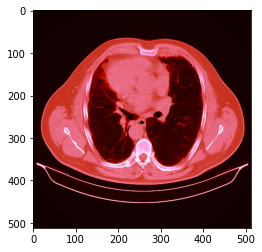

In [14]:
from matplotlib import cm

def show(list_imgs, cmap=cm.bone, rgb=False):
    fig, axs = plt.subplots(config.input_D//10, 10, figsize=(15, 15))
    axs = axs.flatten()
    for i, img in enumerate(list_imgs):
        axs[i].imshow(img[0], cmap=cmap)
        axs[i].set_title(i)
    plt.show()
plt.tight_layout()

batch = train_dataset[1]
imgs_ = batch[0]
# plt.imshow(imgs_[15][0])
# show(imgs_)
imgs_ = np.rollaxis(imgs_, 0, 3)
plt.imshow(imgs_)

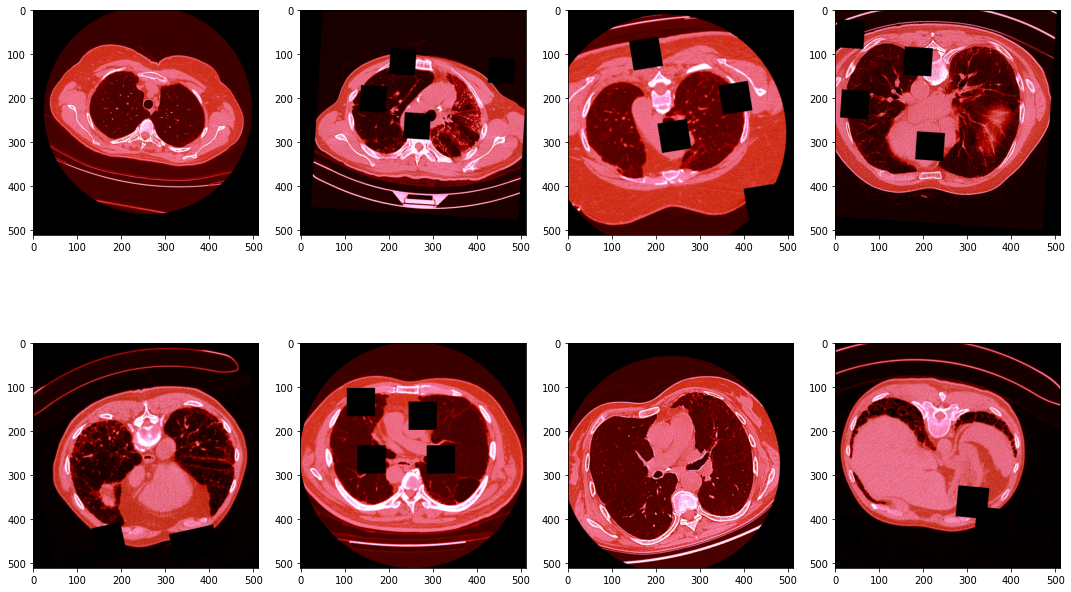

In [15]:
nrow, ncol = 2, 4
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    image = train_dataset[i][0]
    image = np.rollaxis(image, 0, 3)
    ax.imshow(image)
plt.tight_layout()

In [17]:
batch[1]

array([1.        , 0.        , 1.        , 0.        , 0.        ,
       0.20512821, 0.31854492, 0.85714287, 0.35326895], dtype=float32)

#### Model

In [ ]:
!pip install pytorchcv --quiet
!pip install timm --quiet
import timm
from pytorchcv.model_provider import get_model

class FCN(torch.nn.Module):
  def __init__(self, base, in_f, num_classes, in_meta, dropout=True):
    super(FCN, self).__init__()
    self.base = base
    self.after_model = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.5)
    )
    self.meta = nn.Sequential(
        # nn.Linear(in_meta, 100),
        # # nn.BatchNorm1d(100),
        # nn.ReLU(),
        # # nn.Dropout(0.8),
        # nn.Linear(100, 100),
        # # nn.BatchNorm1d(100),
        # nn.ReLU(),
        # # nn.Dropout(0.5)

        nn.Linear(in_meta, 1024),
        # nn.BatchNorm1d(1024),
        nn.ReLU(),
        # nn.Dropout(0.5),
        nn.Linear(1024, 512),
        # nn.BatchNorm1d(512),
        nn.ReLU(),
        # nn.Dropout(0.5)
    )
    self.classification_meta = nn.Sequential(
        # nn.Linear(in_f+100, 1024),
        # nn.BatchNorm1d(1024),
        # nn.ReLU(),
        # nn.Dropout(0.5),
        # nn.Linear(1024, num_classes)
        nn.Linear(in_f+512, num_classes)
        # nn.Linear(in_f+in_meta, num_classes)
    )
    self.classification = nn.Sequential(
        # nn.Linear(in_f+100, 1024),
        # nn.BatchNorm1d(1024),
        # nn.ReLU(),
        # nn.Dropout(0.5),
        # nn.Linear(1024, num_classes)
        nn.Linear(in_f, num_classes)
    )
    self.meta_head = nn.Linear(100, num_classes)
  
  def forward(self, x, meta):
    x = self.base(x)
    x = self.after_model(x)
    meta = self.meta(meta)
    features = torch.cat((x,meta),dim=1)
    x = self.classification_meta(features)
    # x = self.classification(x)
    # x = self.meta_head(meta)
    return x

def create_model(name, path=None):
    model = get_model(name, pretrained=True)
    
    try:
      features = list(model.children())[-1].in_features
    except:
      features = list(model.children())[-1][-1].in_features
    model = nn.Sequential(*list(model.children())[:-1]) # Remove original output layer
    model[0].final_pool = nn.Sequential(nn.AdaptiveAvgPool2d(1))
    # model[-1] = nn.Sequential(nn.AdaptiveAvgPool2d(1))
    model = FCN(model, features, config.n_seg_classes, config.meta_features, dropout=True)

    if path:
      print ('loading pretrained model {}'.format(path))
      pretrain = torch.load(path)['model_state']
      model.load_state_dict(pretrain)

    return model

#### Train Funcs

In [ ]:
def metric(preds, targets):
    sigma = preds[:, 2] - preds[:, 0]
    sigma[sigma < 70] = 70
    delta = (preds[:, 1] - targets).abs()
    delta[delta > 1000] = 1000
    return (-np.sqrt(2) * delta / sigma - torch.log(np.sqrt(2) * sigma)).mean()

def metric2(preds, targets):
    sigma = preds[:, 2] - preds[:, 0]
    sigma[sigma < 70] = 70
    delta = (preds[:, 1] - targets)
    delta = np.abs(delta)
    delta[delta > 1000] = 1000
    return np.mean((-np.sqrt(2) * delta / sigma - np.log(np.sqrt(2) * sigma)))

def score(fvc_true, fvc_pred, sigma=0):
    sigma_clip = np.maximum(sigma, 70)
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return -np.mean(metric)

def quantile_loss(preds, target, quantiles):
    assert not target.requires_grad
    assert preds.size(0) == target.size(0)
    losses = []
    for i, q in enumerate(quantiles):
        errors = target - preds[:, i]
        losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(1))
    loss = torch.mean(torch.mean(torch.cat(losses, dim=1), dim=1))
    return loss

def criterion1(pred1, targets, lambda_=0.8):
    score = -metric(pred1, targets)
    l1 = quantile_loss(pred1, targets, config.quantiles)
    return lambda_*l1 + (1-lambda_)*score
    # l1 = F.mse_loss(pred1, targets)
    # return l1

def train_model(epoch, optimizer, scaler=None, scheduler=None, history=None):
    model.train()
    total_loss = 0

    t = tqdm(train_loader)
    for batch_idx, (img_batch, meta_batch, y_batch) in enumerate(t):
        img_batch = img_batch.cuda().float()
        y_batch = y_batch.cuda().float()
        meta_batch = meta_batch.cuda().float()
        
        rand = np.random.rand()
        if rand < config.mixup:
            pass
        elif rand < config.cutmix:
            pass
        else:
            if config.scale:
              with amp.autocast():
                output1 = model(img_batch, meta_batch)
                loss = criterion1(output1, y_batch) / config.accumulation_steps
            else:
              output1 = model(img_batch, meta_batch)
              loss = criterion1(output1, y_batch) / config.accumulation_steps

        total_loss += loss.data.cpu().numpy() * config.accumulation_steps
        # t.set_description(f'Epoch {epoch+1}/{n_epochs}, LR: %6f, Loss: %.4f'%(optimizer.state_dict()['param_groups'][0]['lr'],total_loss/(batch_idx+1)))

        if history is not None:
          history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
          history.loc[epoch + batch_idx / len(train_loader), 'lr'] = optimizer.state_dict()['param_groups'][0]['lr']
        
        if config.scale:
          scaler.scale(loss).backward()
        elif config.apex:
          with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        else:
          loss.backward()
        
        if (batch_idx+1) % config.accumulation_steps == 0:
          if config.scale:
            scaler.step(optimizer)
            scaler.update()
          else:
            optimizer.step()
          optimizer.zero_grad()
        
        if scheduler is not None:
          scheduler.step(epoch)

def evaluate_model(epoch, scheduler=None, history=None):
    model.eval()
    loss = 0.
    metric_ = 0.
    
    preds_1 = []
    tars_1 = []
    P = []
    with torch.no_grad():
        # t = tqdm(val_loader)
        for img_batch, meta_batch, y_batch, ids in val_loader:
            img_batch = img_batch.cuda().float()
            y_batch = y_batch.cuda().float()
            meta_batch = meta_batch.cuda().float()

            o1 = model(img_batch, meta_batch)

            l1 = criterion1(o1, y_batch)
            loss += l1
            
            # metric_ += metric(o1, y_batch)

            for j in range(len(o1)):
              preds_1.append(o1[j].data.cpu().numpy())
              P.append(ids[j])
            for i in y_batch:
              tars_1.append(i.data.cpu().numpy())
    
    preds_1 = np.array(preds_1)
    
    final_score = metric2(preds_1, tars_1)
    
    loss /= len(val_loader)
    
    if history is not None:
      history.loc[epoch, 'val_loss'] = loss.cpu().numpy()
      history.loc[epoch, 'metric'] = final_score
    
    if scheduler is not None:
      scheduler.step(final_score)

    # print(f'Dev loss: %.4f, Metric: {final_score}, Metric2: {final_score2}'%(loss))
    print(f'Dev loss: %.4f, Metric: {final_score}'%(loss))
    
    with open(log_name, 'a') as f:
      f.write(f'val loss: {loss}\n')
      f.write(f'val Metric: {final_score}\n')
      # f.write(f'val Metric2: {final_score2}\n')

    return P, preds_1, tars_1, loss, final_score

#### Train

In [ ]:
import gc
# err
validations = []

log_name = f"drive/My Drive/logs/log-{len(os.listdir('drive/My Drive/logs/'))}.log"

tars_,preds_,paties_=[],[],[]

for fold in range(5):
    # fold = config.single_fold
    print(f'Train Fold {fold+1}')
    with open(log_name, 'a') as f:
        f.write(f'Train Fold {fold+1}\n\n')

    history = pd.DataFrame()
    history2 = pd.DataFrame()

    torch.cuda.empty_cache()
    gc.collect()

    best = -1e10
    best2 = 1e10
    n_epochs = config.epochs
    early_epoch = 0

    val_dataset = ImageDataset(patients, train_df, meta_df, config.IMAGE_PATH, folds=[fold], mode='val', transform=None)

    train_dataset = ImageDataset(patients, train_df, meta_df, config.IMAGE_PATH, folds=[i for i in np.arange(config.folds) if i != fold], transform=train_transform)

    BATCH_SIZE = config.batch_size

    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False, num_workers=0)

    scaler = amp.GradScaler()

    # model = create_model('efficientnet_b2b')
    model = create_model('resnet50')
    model = model.cuda()

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.lr, betas=(0.9, 0.999), eps=1e-08)

    if config.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, mode='max', factor=0.75, verbose=True, min_lr=1e-5)

    for epoch in range(n_epochs-early_epoch):
        # break
        epoch += early_epoch
        torch.cuda.empty_cache()
        gc.collect()

        with open(log_name, 'a') as f:
            f.write(f'XXXXXXXXXXXXXX-- CYCLE INTER: {epoch+1} --XXXXXXXXXXXXXXXXXXX\n')
            lr_ = optimizer.state_dict()['param_groups'][0]['lr']
            f.write(f'curr lr: {lr_}\n')

        train_model(epoch, optimizer, scaler=scaler, scheduler=None, history=history)

        P, pred, tars, loss, kaggle = evaluate_model(epoch, scheduler=scheduler, history=history2)
        # break
        if kaggle > best:
            best = kaggle
            print(f'Saving best model... (metric)')
            torch.save({
              'model_state': model.state_dict(),
            }, f'drive/My Drive/Models/resnet3d-fld{fold+1}-2.pth')
            with open(log_name, 'a') as f:
                f.write('Saving Best model...\n\n')
        else:
            with open(log_name, 'a') as f:
                f.write('\n')
    print()
    validations.append(best)
    model = create_model('resnet50', path=f'drive/My Drive/Models/resnet3d-fld{fold+1}-2.pth')
    model.cuda()
    pati, pred, tars, loss, kaggle = evaluate_model(0, scheduler=scheduler, history=history2)
    for k,p in enumerate(pred):
      tars_.append(tars[k])
      preds_.append(p)
      paties_.append(pati[k])
    # break

In [ ]:
# CV
final_score1 = metric2(np.array(preds_), np.array(tars_))
final_score1

In [ ]:
# CV for last 3 weeks
idxs=[]
for i,p in enumerate(paties_):
  if i != len(paties_)-1:
    if paties_[i+1]!=p:
      idxs.append(i-2)
      idxs.append(i-1)
      idxs.append(i)
  else:
    idxs.append(i-2)
    idxs.append(i-1)
    idxs.append(i)

In [ ]:
preds2_,tars2_=[],[]
for i,p in enumerate(preds_):
  if i in idxs:
    preds2_.append(p)
    tars2_.append(tars_[i])

In [ ]:
final_score = metric2(np.array(preds2_), np.array(tars2_))
final_score

In [ ]:
with open(log_name, 'a') as f:
    f.write(f'\n5Fold score: {final_score1}')
    f.write(f'\n5Fold score2: {final_score}')

In [ ]:
# oof = pd.DataFrame({'Patient': train_df.Patient, 'pred': preds_, 'target': tars_})
oof = pd.DataFrame({'Patient': paties_, 'pred': preds_, 'target': tars_})
oof.to_csv(f'drive/My Drive/oof-{len(os.listdir("drive/My Drive/"))}.csv', index=False)